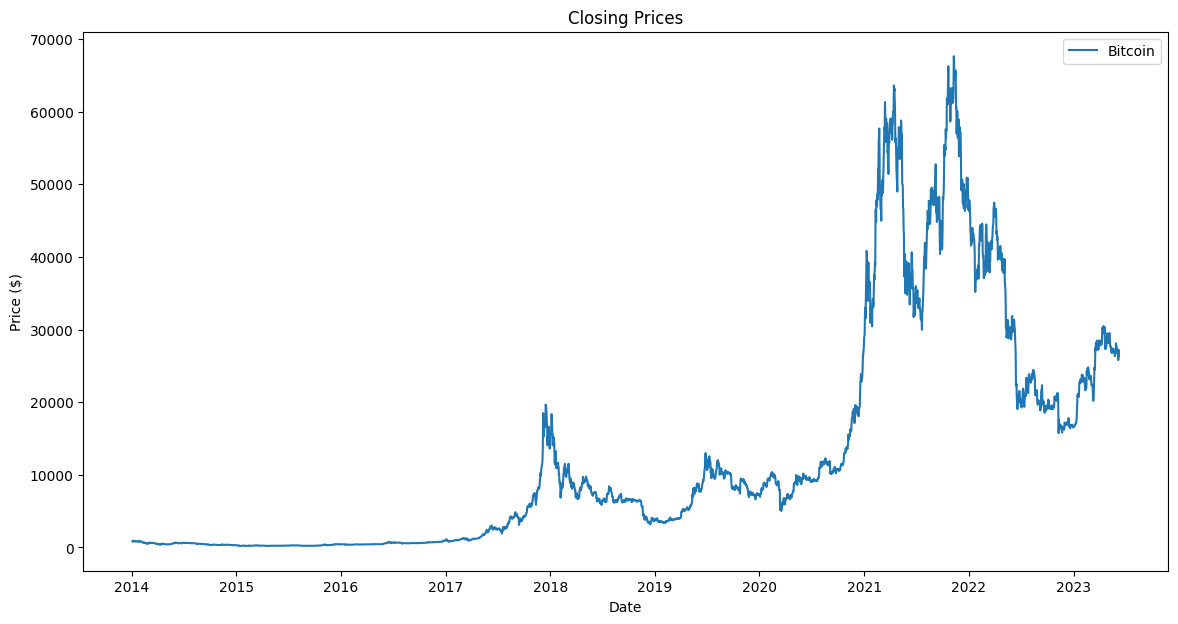

In [35]:
#load data
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras import Model
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

btc_data = pd.read_csv('C:/Users/user/Desktop/btc-usd-max.csv', parse_dates=['snapped_at'], index_col='snapped_at')

# Removing our missing data
btc_data = btc_data.iloc[250:]

# Let's see the chart!
plt.figure(figsize=(14, 7))
plt.plot(btc_data['price'], label='Bitcoin')
plt.title('Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

Epoch 1/60
17/17 [==============================] - 6s 90ms/step - loss: 0.0169 - val_loss: 0.0134
Epoch 2/60
17/17 [==============================] - 1s 33ms/step - loss: 0.0088 - val_loss: 0.0073
Epoch 3/60
17/17 [==============================] - 0s 29ms/step - loss: 0.0050 - val_loss: 0.0040
Epoch 4/60
17/17 [==============================] - 0s 28ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 5/60
17/17 [==============================] - 1s 30ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/60
17/17 [==============================] - 1s 30ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 7/60
17/17 [==============================] - 1s 33ms/step - loss: 0.0011 - val_loss: 9.3117e-04
Epoch 8/60
17/17 [==============================] - 0s 29ms/step - loss: 8.6145e-04 - val_loss: 7.1171e-04
Epoch 9/60
17/17 [==============================] - 0s 29ms/step - loss: 7.2362e-04 - val_loss: 6.0273e-04
Epoch 10/60
17/17 [==============================] - 0s 29ms/step - loss: 6.5888e-04 - va

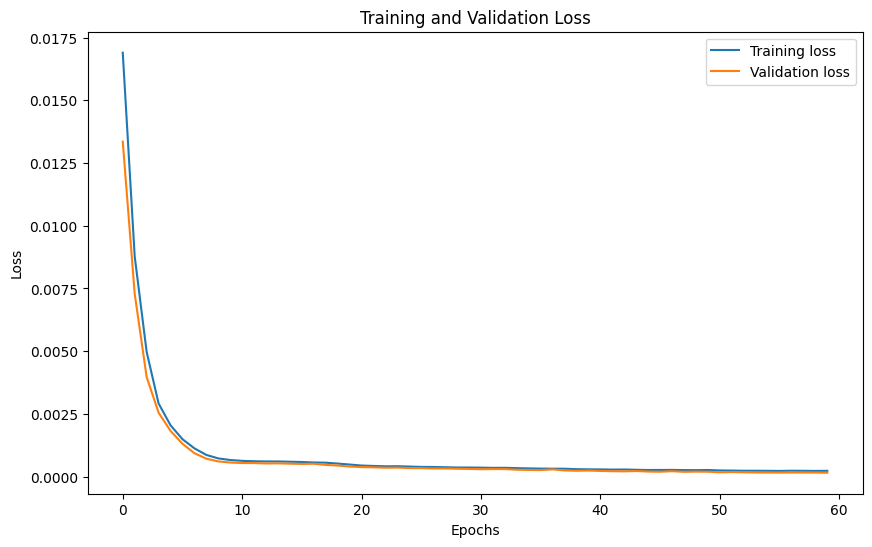

In [36]:
# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-2*seq_length):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length:i+2*seq_length] - data[i+seq_length-1:i+2*seq_length-1]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Normalizing and sequence creation
sequence_length = 6

# Normalize the price data
scaler_price = MinMaxScaler()
btc_price = scaler_price.fit_transform(np.array(btc_data['price']).reshape(-1, 1))

# Normalize the volume data
scaler_volume = MinMaxScaler()
btc_volume = scaler_volume.fit_transform(np.array(btc_data['total_volume']).reshape(-1, 1))

# Combine the normalized price and volume data
btc_data_normalized = np.hstack((btc_price, btc_volume))

# Cut off the data for the last 2 months
cut_off_date = btc_data.index.max() - pd.DateOffset(months=2)
btc_data_last_two_months = btc_data_normalized[btc_data.index > cut_off_date]
btc_data_normalized = btc_data_normalized[btc_data.index <= cut_off_date]


# Create btc_data for last two months
btc_data_last_two_months = btc_data[btc_data.index > cut_off_date]


# Create sequences
btc_sequences, btc_targets = create_sequences(btc_data_normalized, sequence_length)

# Split the sequences into input (X) and output (y) data
X = btc_sequences
y = btc_targets

# Then do the train/test split on X and y separately
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Split the sequences into training, validation, and test data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

from tensorflow.keras.layers import Add, TimeDistributed

class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # Ensure the output is the same shape as the input.
        output = inputs[:, :, :] + delta
        return output


# Define the LSTM model to be wrapped
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(128, return_sequences=True),  # This LSTM also needs to return sequences.
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2, kernel_initializer=tf.initializers.zeros())),  # Using TimeDistributed to apply the Dense layer to each time step.
])

# Now wrap it
residual_lstm = ResidualWrapper(lstm_model)


# Compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
residual_lstm.compile(optimizer=optimizer, loss='mse')

# Train
history = residual_lstm.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=128,
    epochs=60,
    verbose=1,
)

# Predict
y_pred = residual_lstm.predict(X_test)

# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [51]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 0.015484939364632097
Mean Squared Error (MSE): 0.0005303665979361418
Root Mean Squared Error (RMSE): 0.023029689488487284


In [52]:
# Swing Trading
btc_held = 0
portfolio = 10000  # Initial portfolio value
btc_amount = 0
trade_type = None
profit_or_loss = 0
FFPS_ratio = 0.02  

# Create a new dataframe based on last two months
btc_data_last_two_months = btc_data[-60:].copy()
btc_data_last_two_months['SMA_30'] = btc_data_last_two_months['price'].rolling(window=30).mean()

trades = pd.DataFrame(columns=['portfolio_value', 'trade_type'])

# Loop through the data for the last two months
for i in range(30, len(btc_data_last_two_months)):  # Start from 30 because we now have SMA_30
    signal = np.sign(btc_data_last_two_months['price'].iloc[i] - btc_data_last_two_months['SMA_30'].iloc[i])

    if signal == 1 and btc_held == 0:  # Buy signal
        spend = FFPS_ratio * portfolio
        btc_amount = spend / btc_data_last_two_months['price'].iloc[i]
        portfolio -= spend
        btc_held += btc_amount
        trade_type = 'Buy'
        trades = pd.concat([trades, pd.DataFrame({'portfolio_value': [portfolio], 'trade_type': [trade_type]})],
                           ignore_index=True)

    elif signal == -1 and btc_held > 0:  # Sell signal
        btc_amount = btc_held
        spend = btc_amount * btc_data_last_two_months['price'].iloc[i]
        portfolio += spend
        btc_held = 0
        trade_type = 'Sell'
        trades = pd.concat([trades, pd.DataFrame({'portfolio_value': [portfolio], 'trade_type': [trade_type]})],
                           ignore_index=True)

    if i > 30 and trade_type == 'Sell':
        profit_or_loss = portfolio - trades['portfolio_value'].iloc[-2] if len(trades) > 0 else 0
    else:
        profit_or_loss = 0

print("Initial Portfolio Value:", 10000)
print("Final Portfolio Value:", portfolio)

Initial Portfolio Value: 10000
Final Portfolio Value: 9987.454876264064


In [53]:
# Let's try a different strategy
# Normalize the price data
btc_price = scaler_price.transform(np.array(btc_data_last_two_months['price']).reshape(-1, 1))

# Normalize the volume data
btc_volume = scaler_volume.transform(np.array(btc_data_last_two_months['total_volume']).reshape(-1, 1))

# Combine the normalized price and volume data
btc_data_last_two_months_normalized = np.hstack((btc_price, btc_volume))

# Create sequences for last two months
btc_sequences_last_two_months, _ = create_sequences(btc_data_last_two_months_normalized, sequence_length)

# Initialize empty list to store trades and predicted prices
trades = []
y_pred_rescaled_last_two_months = []

# Loop through each sequence in the last two months
for i in range(len(btc_sequences_last_two_months)):
    # Predict for this sequence
    y_pred = residual_lstm.predict(np.expand_dims(btc_sequences_last_two_months[i], axis=0))

    # Reshape and rescale the predictions
    y_pred_rescaled = scaler_price.inverse_transform(y_pred[0, :, 0].reshape(-1, 1))

    # Append to list of all predictions
    y_pred_rescaled_last_two_months.append(y_pred_rescaled.flatten())

# Extract actual prices for the last two months
btc_price_last_two_months = np.array(btc_data_last_two_months['price']).reshape(-1, 1)


# Define the initial portfolio
portfolio = 10000

# Initialize empty list to store trades with date
trades_with_date = []

# Loop through each sequence in the test set
for i in range(len(y_pred_rescaled_last_two_months)):
    sequence_trades = []
    # Loop through each period in the sequence
    for j in range(sequence_length - 1):  # avoid last value for comparison
        pred_diff = y_pred_rescaled_last_two_months[i][j + 1] - y_pred_rescaled_last_two_months[i][j]
        actual_diff = btc_price_last_two_months[i+j+1] - btc_price_last_two_months[i+j]

        # Get the date of the trade
        trade_date = btc_data_last_two_months.index[i+j]

        # If prediction for next period is higher than current period, then buy
        if pred_diff > 0.01:  # 0.01 is an example threshold for making trades
            trade = actual_diff  # profit is equal to the actual price change

            # Calculate the number of shares to buy
            shares_to_buy = portfolio / btc_price_last_two_months[i+j]
            
            # Update the portfolio
            portfolio += shares_to_buy * trade
        else:  # If prediction for next period is not higher, then do nothing (i.e., don't buy)
            trade = 0
        
        sequence_trades.append((trade_date, trade))
    trades_with_date.append(sequence_trades)

# Flatten the trades list
flattened_trades_with_date = [trade for sequence in trades_with_date for trade in sequence]

# Print trades and total profit/loss
for i, trade in enumerate(flattened_trades_with_date):
    print(f"Trade {i+1} on {trade[0]}: {'Buy' if trade[1] > 0 else 'Sell'} with {'profit' if trade[1] > 0 else 'loss'} of {trade[1]}")

print(f"Initial portfolio: 10000")
print(f"Final portfolio: {portfolio}")


1/1 [==============================] - 0s 32ms/step
Trade 1 on 2023-04-10 00:00:00+00:00: Sell with loss of 0
Trade 2 on 2023-04-11 00:00:00+00:00: Buy with profit of [602.96197254]
Trade 3 on 2023-04-12 00:00:00+00:00: Sell with loss of [-356.79741469]
Trade 4 on 2023-04-13 00:00:00+00:00: Sell with loss of 0
Trade 5 on 2023-04-14 00:00:00+00:00: Sell with loss of 0
Trade 6 on 2023-04-11 00:00:00+00:00: Sell with loss of 0
Trade 7 on 2023-04-12 00:00:00+00:00: Sell with loss of [-356.79741469]
Trade 8 on 2023-04-13 00:00:00+00:00: Buy with profit of [500.88861806]
Trade 9 on 2023-04-14 00:00:00+00:00: Sell with loss of 0
Trade 10 on 2023-04-15 00:00:00+00:00: Sell with loss of [-156.24682093]
Trade 11 on 2023-04-12 00:00:00+00:00: Sell with loss of 0
Trade 12 on 2023-04-13 00:00:00+00:00: Buy with profit of [500.88861806]
Trade 13 on 2023-04-14 00:00:00+00:00: Sell with loss of 0
Trade 14 on 2023-04-15 00:00:00+00:00: Sell with loss of [-156.24682093]
Trade 15 on 2023-04-16 00:00:00+0

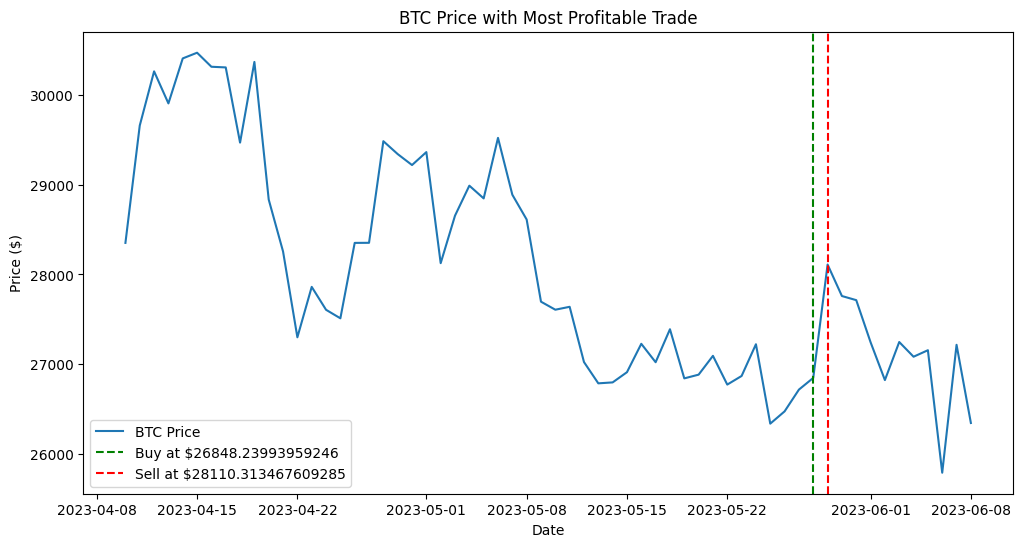

Profit made on the most profitable trade: $[1262.07352802]


In [55]:
# Find the index of the most profitable trade
most_profitable_trade_index = np.argmax([trade[1] for trade in flattened_trades_with_date])

# Get the most profitable trade
most_profitable_trade = np.array(flattened_trades_with_date, dtype=object)[most_profitable_trade_index]

# Get the entry and exit dates
entry_date = most_profitable_trade[0]
exit_date = flattened_trades_with_date[most_profitable_trade_index + 1][0]

# Get the Bitcoin price data for the plot
btc_price_plot = btc_data_last_two_months['price']

# Create the plot
plt.figure(figsize=(12,6))
plt.plot(btc_price_plot, label='BTC Price')
plt.axvline(x=entry_date, color='g', linestyle='--', label='Buy at $' + str(btc_price_plot[entry_date]))
plt.axvline(x=exit_date, color='r', linestyle='--', label='Sell at $' + str(btc_price_plot[exit_date]))
plt.title('BTC Price with Most Profitable Trade')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# Print the profit made on the most profitable trade
print('Profit made on the most profitable trade: $' + str(most_profitable_trade[1]))
